In [249]:
library(repr)
library(tidyverse)
library(tidymodels)
library(gridExtra)
set.seed(1)
options(repr.matrix.max.rows = 10)

In [250]:
players_data<-read_csv("https://raw.githubusercontent.com/lilypurdy/toy_ds_project/refs/heads/main/players%20(2).csv")
head(players_data, 5)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21


In [251]:
clean_players_data <- read_csv("https://raw.githubusercontent.com/Jamesnam1/toy_ds_project/refs/heads/main/players.csv",
    col_names = c("experience", "subscribed", "hashed_email", "hours_played", "name", "gender", "age"),
                col_types = list("c", "l", "c", "d", "c", "c", "i"))
clean_players_data

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


experience,subscribed,hashed_email,hours_played,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
experience,NA,hashedEmail,NA,name,gender,NA
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


In [252]:
players <- clean_players_data |>
  select(-hashed_email, -subscribed, -name, -gender) |>
  filter(!is.na(age)) |>
  mutate(
    experience = case_when(
      experience == "Pro" ~ 5,
      experience == "Veteran" ~ 4,
      experience == "Amateur" ~ 3,
      experience == "Regular" ~ 2,
      experience == "Beginner" ~ 1,
      TRUE ~ NA_real_
    )
  )
players

experience,hours_played,age
<dbl>,<dbl>,<int>
5,30.3,9
4,3.8,17
4,0.0,17
3,0.7,21
2,0.1,21
⋮,⋮,⋮
3,0.0,20
3,0.0,17
4,0.3,22


In [253]:
set.seed(2)

split_data <- initial_split(players, prop = 3/4, strata = hours_played)

training_data <- training(split_data)
testing_data <- testing(split_data)

head(training_data)

experience,hours_played,age
<dbl>,<dbl>,<int>
4,0.0,17
2,0.1,21
3,0.0,17
3,0.0,21
3,0.1,17
5,0.0,17


In [254]:
set.seed(2)

data_recipe <- recipe(hours_played ~ age + experience, data = training_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

data_vfold <- vfold_cv(training_data, v = 5, strata = hours_played)

data_wkflw <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(data_spec)

data_wkflw

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [255]:
set.seed(2)
gridvals <- tibble(neighbors = seq(1, 100))
data_multi <- data_wkflw |>
  tune_grid(resamples = data_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse") |>
  filter(mean == min(mean, na.rm = TRUE))

data_k <- data_multi |> pull(neighbors)
data_k

[1] 100

In [256]:
set.seed(2)
final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = data_k) |>
  set_engine("kknn") |>
  set_mode("regression")

knn_mult_fit <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(final_spec) |>
  fit(data = training_data)

# Step 8: Evaluate on testing data
knn_mult_preds <- knn_mult_fit |>
  predict(testing_data) |>
  bind_cols(testing_data)

knn_mult_mets <- metrics(knn_mult_preds, truth = hours_played, estimate = .pred) |>
  filter(.metric == "rmse")

print(knn_mult_mets)

# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard        33.0


In [257]:
set.seed(2)

age_prediction_grid <- expand_grid(
  age = seq(
    from = players |> pull(age) |> min(na.rm = TRUE),
    to = players |> pull(age) |> max(na.rm = TRUE),
    by = 10
  ),
  experience = 1:5)

age_prediction_grid


age,experience
<dbl>,<int>
8,1
8,2
8,3
8,4
8,5
⋮,⋮
48,1
48,2
48,3


Warning message in scale_y_log10(labels = comma):
“log-10 transformation introduced infinite values.”


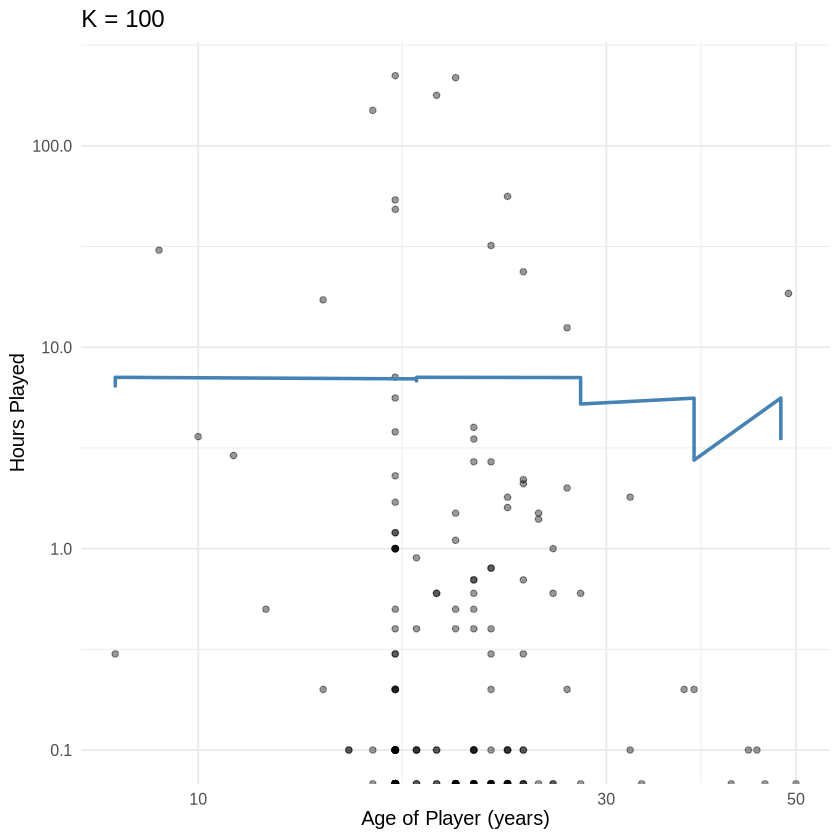

In [258]:

data_preds <- knn_mult_fit  |>
  predict(age_prediction_grid) |>
  bind_cols(age_prediction_grid)

plot_final <- ggplot(players, aes(x = age, y = hours_played)) +
  geom_point(alpha = 0.4) +
  geom_line(data = data_preds, aes(x = age, y = .pred), color = "steelblue", linewidth = 1) +
  xlab("Age of Player (years)") +
  ylab("Hours Played") +
  ggtitle(paste0("K = ", data_k)) +
  scale_y_log10(labels = comma) +
  scale_x_log10(labels = comma) +
  theme_minimal(base_size = 12)

plot_final